In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import pandas as pd

In [2]:
ds=xr.open_dataset("/seq001/data/EAC_filled-daily-distance-depth-gridded-product_20120401-20220727.nc").sel(TIME=slice("2018-01-01","2019-01-01"))
ds

<xarray.Dataset>
Dimensions:    (TIME: 366, DEPTH: 271, LONGITUDE: 124)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2018-01-01T12:00:00 ... 2019-01-01T12:00:00
  * DEPTH      (DEPTH) float64 0.0 10.0 20.0 30.0 ... 4.96e+03 4.98e+03 5e+03
  * LONGITUDE  (LONGITUDE) float64 153.6 153.6 153.6 153.6 ... 155.3 155.3 155.3
    LATITUDE   (LONGITUDE) float64 ...
Data variables:
    TEMP       (TIME, DEPTH, LONGITUDE) float64 ...
    PSAL       (TIME, DEPTH, LONGITUDE) float64 ...
    UCUR       (TIME, DEPTH, LONGITUDE) float64 ...
    VCUR       (TIME, DEPTH, LONGITUDE) float64 ...
Attributes: (12/38)
    project:                       Integrated Marine Observing System (IMOS),...
    Conventions:                   CF-1.6,IMOS-1.4
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         East Australian Current gridded (depth, di...
    date_created:                  2023-08-07T11:36:12Z
    date_modified:                 2023-08-07T11:36:12Z
    ...                            ...
    citation:                      The citation in a list of references is: "...
    persistent_URL:                https://hdl.handle.net/102.100.100/434305
    acknowledgement:               This project is supported with funding fro...
    disclaimer:                    Data, products and services from CSIRO are...
    license:                       http://creativecommons.org/licenses/by/4.0/
    comment:                       Data from the IMOS North Stradbroke Island...

In [ ]:
#Pentads to match ROMS
# you might also want to make 5-day averages
def calc_5dayDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'TIME' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'TIME' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(TIME='5D').mean('TIME')])
    print('done downsampling')
    return ds_workaround


ds=calc_5dayDownsample(ds)
ds


In [13]:
#volume trasnport calculate (me code)

# Extract velocity components 
v_velocity = ds['VCUR']
u_velocity = ds['UCUR']


#get coordinates
lon = ds['LONGITUDE']
lat = ds['LATITUDE']

# Define the depth coordinates
#depth = ds['DEPTH'].isel(DEPTH=slice(0,101)) #0-2000m
depth1000=ds['DEPTH'].sel(DEPTH=slice(0,1000))
depthfull=ds['DEPTH']

#approximate lengths
dxdy=111139*np.sqrt((lon.diff(dim='LONGITUDE')**2+lat.diff(dim='LONGITUDE')**2))
dz1000=depth1000.diff(dim='DEPTH')
dzfull=depthfull.diff(dim='DEPTH')
area1000=dxdy*dz1000
areafull=dxdy*dzfull

transport1000=(v_velocity*area1000).sum(dim='LONGITUDE').sum(dim='DEPTH')/1e6
transportfull=(v_velocity*areafull).sum(dim='LONGITUDE').sum(dim='DEPTH')/1e6

[Text(0.5, 1.0, 'Net Volume Transport'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Transport (Sv)')]

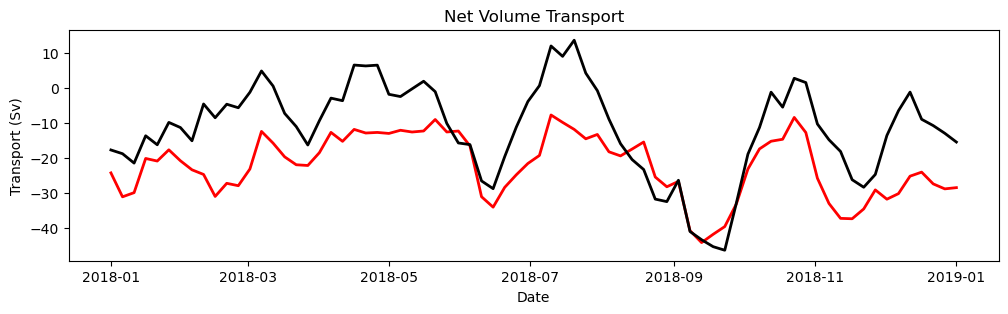

In [14]:
fig, ax=plt.subplots(figsize=(12, 3))

ax.plot(transport1000.TIME, transport1000.values,linewidth=2,color='red')
ax.plot(transportfull.TIME, transportfull.values,linewidth=2,color='black')
ax.set(title = "Net Volume Transport",
       xlabel = "Date",
       ylabel = "Transport (Sv)")

In [11]:
#heat transport

# Extract variables
temperature = ds['TEMP']+273.15 

# Extract velocity components 
v_velocity = ds['VCUR']
u_velocity = ds['UCUR']


#get coordinates
lon = ds['LONGITUDE']
lat = ds['LATITUDE']

# Define the depth coordinates
#depth = ds['DEPTH'].isel(DEPTH=slice(0,101)) #0-2000m
depth1000=ds['DEPTH'].sel(DEPTH=slice(0,1000))
depthfull=ds['DEPTH']

# Define constants
density = 1026.0  # Example value for seawater density in kg/m³
specific_heat_capacity = 4181.3  # Example value for specific heat capacity in J/(kg·K)


#calculate grid spacing and area
dxdy=111139*np.sqrt((lon.diff(dim='LONGITUDE')**2+lat.diff(dim='LONGITUDE')**2))
dz1000=depth1000.diff(dim='DEPTH')
dzfull=depthfull.diff(dim='DEPTH')
area1000=dxdy*dz1000
areafull=dxdy*dzfull

#calculate flux
heat_transport1000=(density*specific_heat_capacity*temperature *v_velocity*area1000).sum(dim='LONGITUDE').sum(dim='DEPTH')
heat_PW1000=heat_transport1000/1e15

heat_transportfull=(density*specific_heat_capacity*temperature *v_velocity*areafull).sum(dim='LONGITUDE').sum(dim='DEPTH')
heat_PWfull=heat_transportfull/1e15


[Text(0.5, 1.0, 'Heat Transport'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Heat Flux (PW)')]

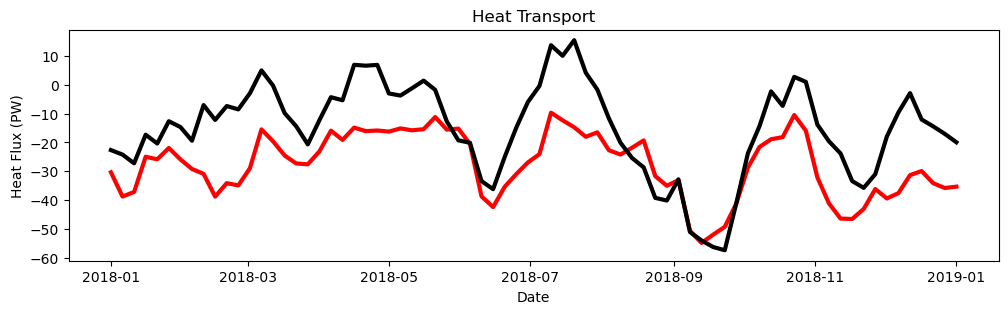

In [12]:
fig, ax=plt.subplots(figsize=(12, 3))

ax.plot(heat_PW1000.TIME, heat_PW1000.values,linewidth=3,color='red')
ax.plot(heat_PWfull.TIME, heat_PWfull.values,linewidth=3,color='black')
ax.set(title = "Heat Transport",
       xlabel = "Date",
       ylabel = "Heat Flux (PW)")

In [15]:
#Load in Model
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn_processed.nc")
ds_grid=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn_grid_vars.nc")
ds

<xarray.Dataset>
Dimensions:          (ocean_time: 73, bnds: 2, s_rho: 31, s_w: 32, tracer: 2,
                      boundary: 4, Nuser: 1, eta_rho: 600, xi_rho: 800,
                      xi_u: 799, eta_v: 599)
Coordinates:
  * ocean_time       (ocean_time) datetime64[ns] 2025-12-30 ... 2026-12-25
  * s_rho            (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w              (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    lat_rho          (eta_rho, xi_rho) float64 ...
    lon_rho          (eta_rho, xi_rho) float64 ...
    z_w              (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    z_rho            (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0           (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: bnds, tracer, boundary, Nuser, eta_rho, xi_rho,
                                xi_u, eta_v
Data variables: (12/51)
    ocean_time_bnds  (ocean_time, bnds) datetime64[ns] ...
    nl_tnu2          (tracer) float64 ...
    LtracerSponge    (tracer) int32 ...
    Akt_bak          (tracer) float64 ...
    Tnudg            (tracer) float64 ...
    FSobc_in         (boundary) float64 ...
    ...               ...
    z_u              (ocean_time, s_rho, eta_rho, xi_u) float64 ...
    z_v              (ocean_time, s_rho, eta_v, xi_rho) float64 ...
    dx               (eta_rho, xi_rho) float64 ...
    dy               (eta_rho, xi_rho) float64 ...
    dz               (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    dA               (eta_rho, xi_rho) float64 ...
Attributes: (12/38)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.4, SGRID-0.3
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    ...                         ...
    history:                    Mon Feb 19 09:22:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Feb 19 09:22:01 2024: Appended file ROMS_...

In [16]:
dates = pd.to_datetime(ds['ocean_time'].values)  # Convert the numpy array of dates to Pandas datetime objects
modified_dates = [date.replace(year=2018) for date in dates]
modified_dates[0] = [date.replace(year=2017) for date in dates][0]
ds['ocean_time'] = modified_dates
ds_grid['ocean_time'] = modified_dates
ds

<xarray.Dataset>
Dimensions:          (ocean_time: 73, bnds: 2, s_rho: 31, s_w: 32, tracer: 2,
                      boundary: 4, Nuser: 1, eta_rho: 600, xi_rho: 800,
                      xi_u: 799, eta_v: 599)
Coordinates:
  * ocean_time       (ocean_time) datetime64[ns] 2017-12-30 ... 2018-12-25
  * s_rho            (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w              (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    lat_rho          (eta_rho, xi_rho) float64 ...
    lon_rho          (eta_rho, xi_rho) float64 ...
    z_w              (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    z_rho            (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0           (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: bnds, tracer, boundary, Nuser, eta_rho, xi_rho,
                                xi_u, eta_v
Data variables: (12/51)
    ocean_time_bnds  (ocean_time, bnds) datetime64[ns] ...
    nl_tnu2          (tracer) float64 ...
    LtracerSponge    (tracer) int32 ...
    Akt_bak          (tracer) float64 ...
    Tnudg            (tracer) float64 ...
    FSobc_in         (boundary) float64 ...
    ...               ...
    z_u              (ocean_time, s_rho, eta_rho, xi_u) float64 ...
    z_v              (ocean_time, s_rho, eta_v, xi_rho) float64 ...
    dx               (eta_rho, xi_rho) float64 ...
    dy               (eta_rho, xi_rho) float64 ...
    dz               (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    dA               (eta_rho, xi_rho) float64 ...
Attributes: (12/38)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.4, SGRID-0.3
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    ...                         ...
    history:                    Mon Feb 19 09:22:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Feb 19 09:22:01 2024: Appended file ROMS_...

In [17]:
def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

grid = makeROMSGridObject(ds_grid)

In [18]:
dA_x = (1/ds.pm)*ds.dz
trans_v=ds.v_northward*dA_x
trans_v_1000=trans_v.where((ds.z_rho0>-1000).compute(),drop=True)

In [19]:
rho0=1026
cp0=4181.3
dA_x = (1/ds.pm)*ds.dz
heat_v=rho0*cp0*ds.v_northward*(ds.temp+273.15)*dA_x
del(dA_x)
heat_v_1000=heat_v.where((ds.z_rho0>-1000).compute(),drop=True)

<Figure size 640x480 with 0 Axes>

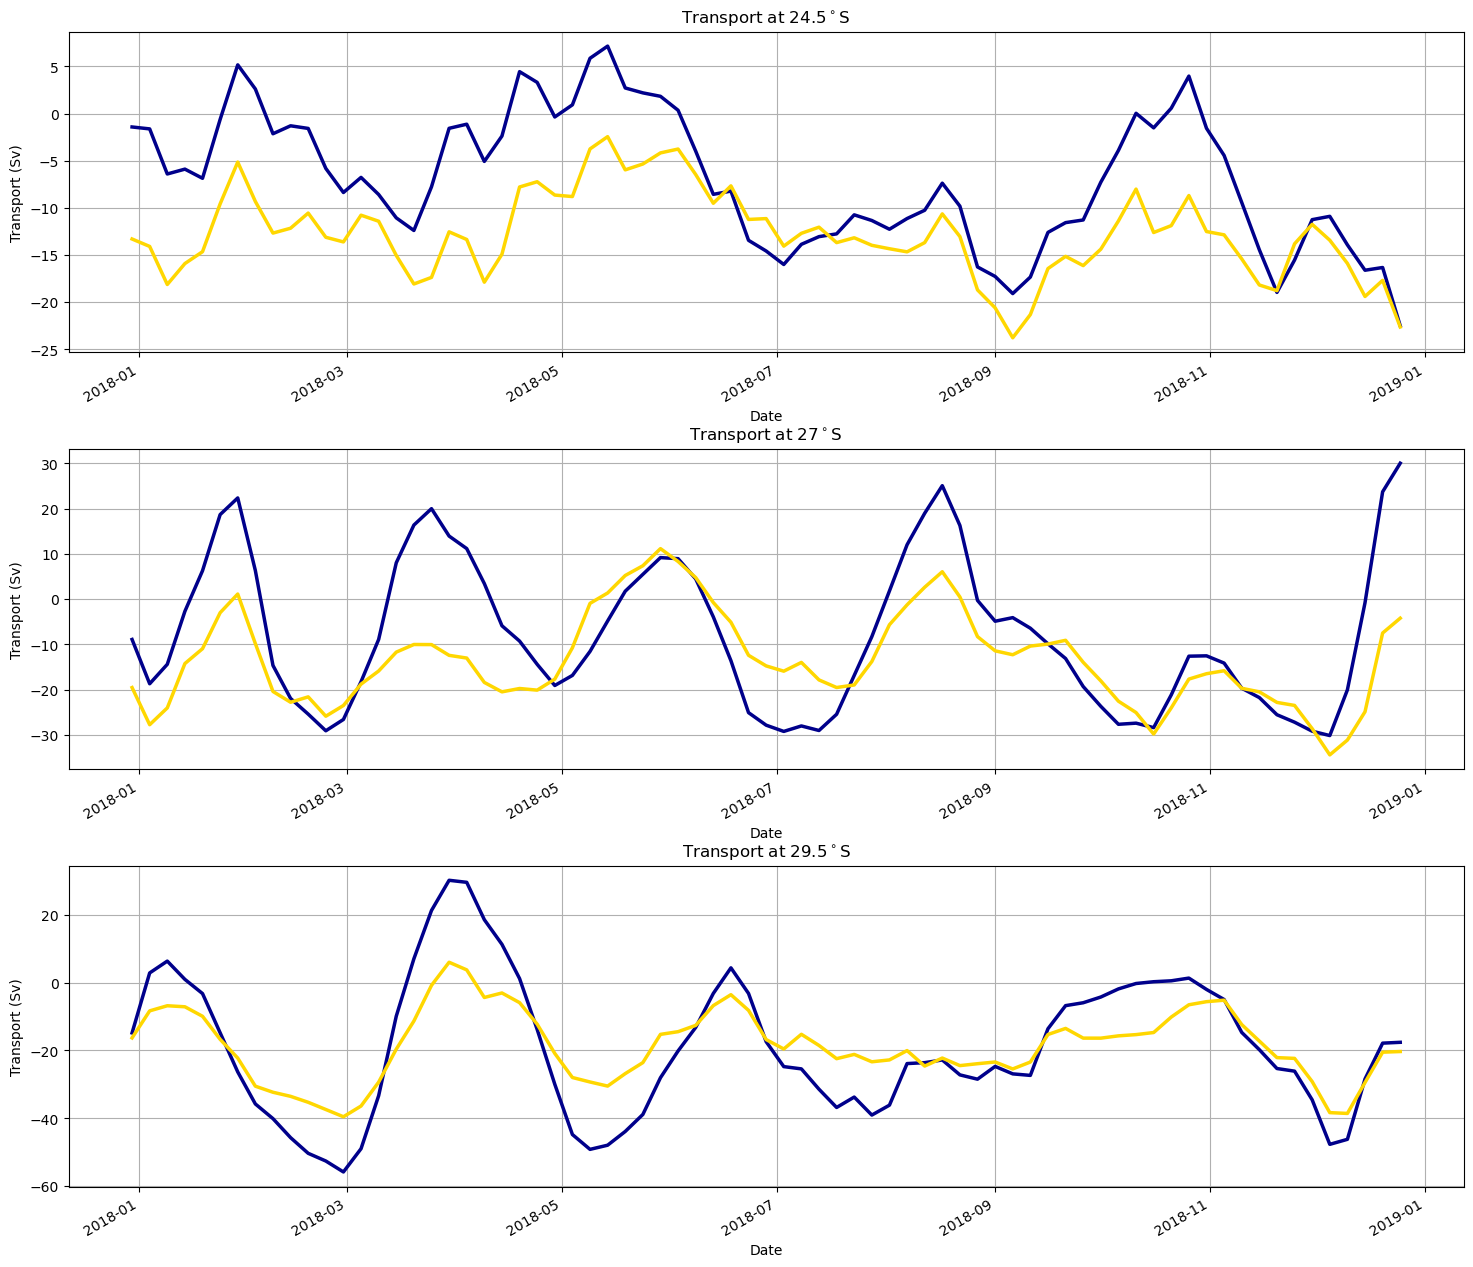

In [17]:
gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,15])#what is this?
ax = None


ax = fig.add_subplot(gs[0,0])


(trans_v.isel(eta_rho=550,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="darkblue",linewidth=2.5)
(trans_v_1000.isel(eta_rho=550,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="gold",linewidth=2.5)
plt.title('Transport at 24.5$^\circ$S')
plt.xlabel('Date')
plt.ylabel('Transport (Sv)')
plt.grid()


ax = fig.add_subplot(gs[1,0])
(trans_v.isel(eta_rho=300,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="darkblue",linewidth=2.5)
(trans_v_1000.isel(eta_rho=300,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="gold",linewidth=2.5)
plt.title('Transport at 27$^\circ$S')
plt.xlabel('Date')
plt.ylabel('Transport (Sv)')
plt.grid()

ax = fig.add_subplot(gs[2,0])
(trans_v.isel(eta_rho=50,xi_rho=slice(180,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="darkblue",linewidth=2.5)
(trans_v_1000.isel(eta_rho=50,xi_rho=slice(180,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="gold",linewidth=2.5)
plt.title('Transport at 29.5$^\circ$S')

plt.xlabel('Date')
plt.ylabel('Transport (Sv)')
plt.grid()

(-65.0, 40.0)

<Figure size 640x480 with 0 Axes>

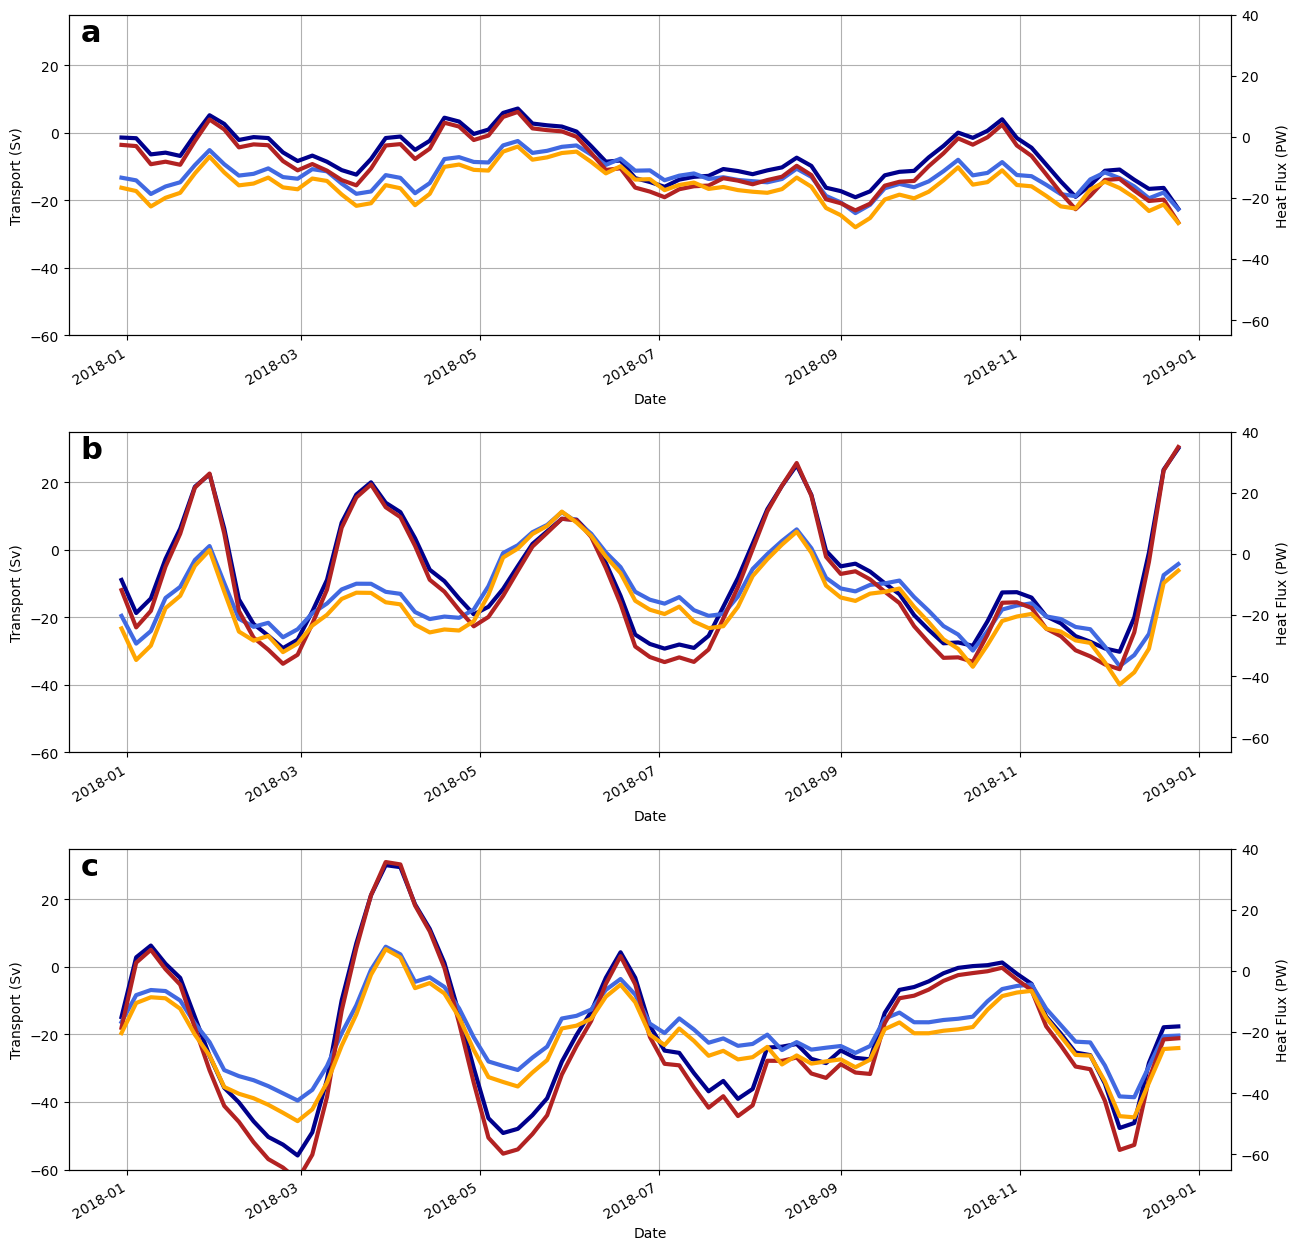

In [47]:
gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])#what is this?
ax = None


ax = fig.add_subplot(gs[0,0])
(trans_v.isel(eta_rho=550,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="darkblue",linewidth=3)
(trans_v_1000.isel(eta_rho=550,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="royalblue",linewidth=3)
plt.xlabel('Date')
plt.ylabel('Transport (Sv)')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
plt.grid()
plt.ylim(-60,35)
ax2 = ax.twinx()
(heat_v.isel(eta_rho=550,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e15).plot(color="firebrick",linewidth=3)
(heat_v_1000.isel(eta_rho=550,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e15).plot(color="orange",linewidth=3)
plt.ylabel('Heat Flux (PW)')
plt.ylim(-65,40)

ax = fig.add_subplot(gs[1,0])
(trans_v.isel(eta_rho=300,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="darkblue",linewidth=3)
(trans_v_1000.isel(eta_rho=300,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="royalblue",linewidth=3)
plt.xlabel('Date')
plt.ylabel('Transport (Sv)')
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
plt.grid()
plt.ylim(-60,35)
ax2 = ax.twinx()
(heat_v.isel(eta_rho=300,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e15).plot(color="firebrick",linewidth=3)
(heat_v_1000.isel(eta_rho=300,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e15).plot(color="orange",linewidth=3)
plt.ylabel('Heat Flux (PW)')
plt.ylim(-65,40)

ax = fig.add_subplot(gs[2,0])
(trans_v.isel(eta_rho=50,xi_rho=slice(180,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="darkblue",linewidth=3)
(trans_v_1000.isel(eta_rho=50,xi_rho=slice(180,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="royalblue",linewidth=3)
plt.xlabel('Date')
plt.ylabel('Transport (Sv)')
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
plt.grid()
plt.ylim(-60,35)
ax2 = ax.twinx()
(heat_v.isel(eta_rho=50,xi_rho=slice(180,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e15).plot(color="firebrick",linewidth=3)
(heat_v_1000.isel(eta_rho=50,xi_rho=slice(180,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e15).plot(color="orange",linewidth=3)
plt.ylabel('Heat Flux (PW)')
plt.ylim(-65,40)

(-65.0, 40.0)

<Figure size 640x480 with 0 Axes>

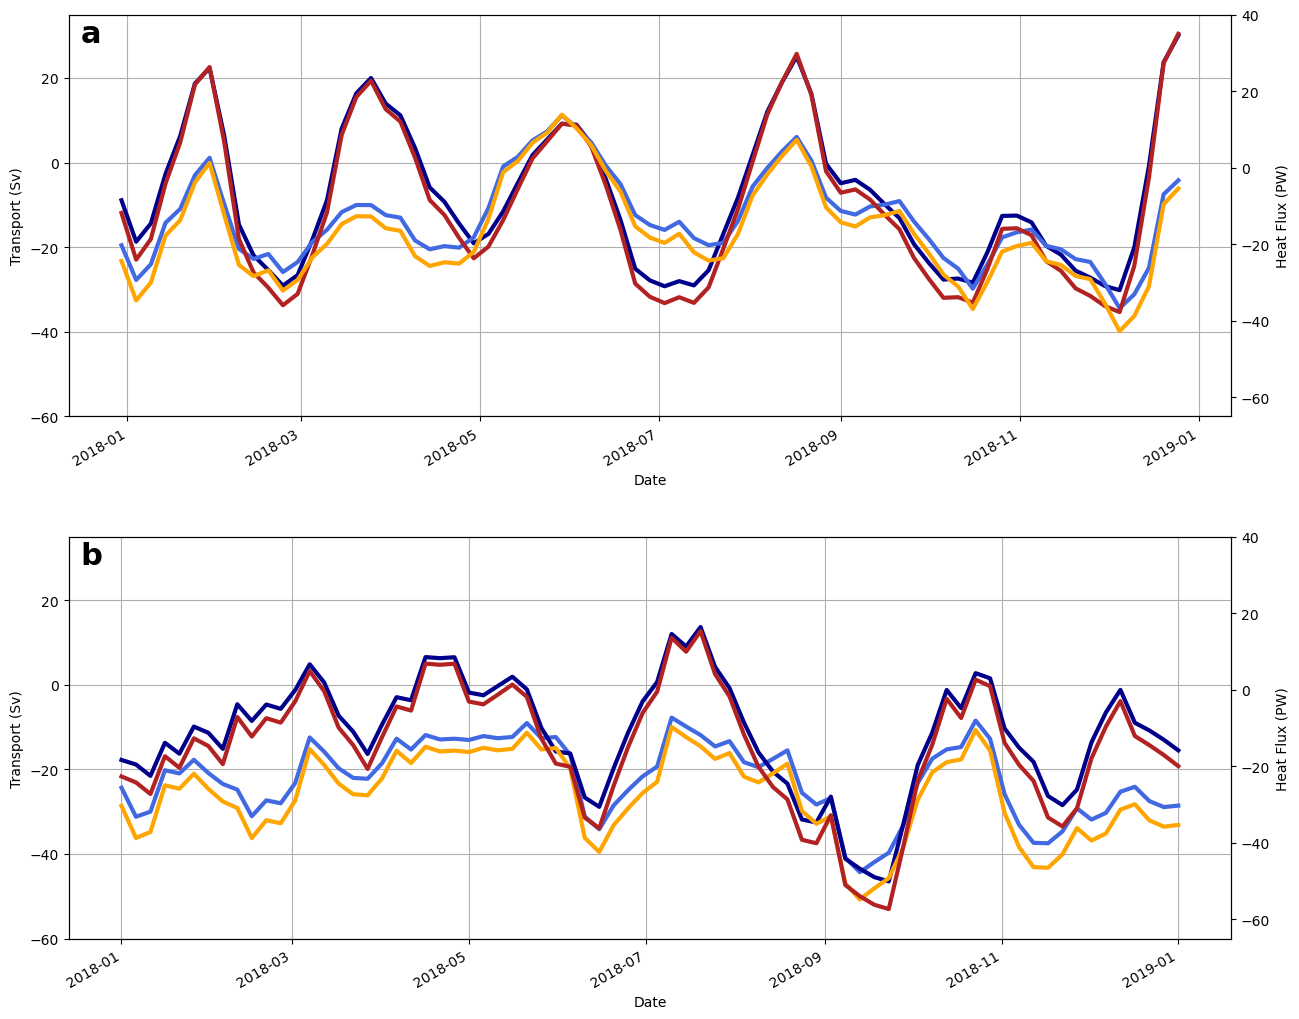

: 

In [28]:
gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.2, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,12])#what is this?
ax = None


ax = fig.add_subplot(gs[0,0])
(trans_v.isel(eta_rho=300,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="darkblue",linewidth=3)
(trans_v_1000.isel(eta_rho=300,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e6).plot(color="royalblue",linewidth=3)
plt.xlabel('Date')
plt.ylabel('Transport (Sv)')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
plt.grid()
plt.ylim(-60,35)
ax2 = ax.twinx()
(heat_v.isel(eta_rho=300,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e15).plot(color="firebrick",linewidth=3)
(heat_v_1000.isel(eta_rho=300,xi_rho=slice(185,400)).sum(dim='xi_rho').sum(dim='s_rho')/1e15).plot(color="orange",linewidth=3)
plt.ylabel('Heat Flux (PW)')
plt.ylim(-65,40)


ax = fig.add_subplot(gs[1,0])
ax.plot(transport1000.TIME, transport1000.values,linewidth=3,color='royalblue')
ax.plot(transportfull.TIME, transportfull.values,linewidth=3,color='darkblue')
plt.xticks(rotation=30,ha='right')
plt.xlabel('Date')
plt.ylabel('Transport (Sv)')
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
plt.grid()
plt.ylim(-60,35)
ax2 = ax.twinx()
ax2.plot(heat_PW1000.TIME, heat_PW1000.values,linewidth=3,color='orange')
ax2.plot(heat_PWfull.TIME, heat_PWfull.values,linewidth=3,color='firebrick')
plt.ylabel('Heat Flux (PW)')
plt.ylim(-65,40)
